In [ ]:
# This script plots the networks for a single simulation run. 
# This was meant for writing the report, but it can be used to visualize the networks generated by the simulation.

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree

import json
import networkx as nx
import os

import networkx as nx
import numpy as np
from dataclasses import dataclass, field
from scipy.spatial import cKDTree
from tqdm.notebook import trange, tqdm
from collections import defaultdict
import os
import json

In [2]:
@dataclass
class ResultSet:
    """
    Helper class to keep all results from a single experiment together
    """
    path: str
    all_trails: np.array
    seed: np.array
    nuclei: np.array
    stations: np.array
    map_with_stations: np.array
    start_pos: np.array
    all_points: np.array = field(init=False)
    station_indices: range = field(init=False)

    def __post_init__(self):
        points = self.nuclei.reshape(-1, 2)
        points = points[~np.all(points == 0, axis=1)]  # Remove zero points
        self.all_points = np.vstack([points, self.stations])
        
        self.station_indices = range(self.all_points.shape[0] - len(self.stations), self.all_points.shape[0])

    def __str__(self):
        return f"Experiment with start pos {self.start_pos}, seed {self.seed}"

In [3]:
def create_nuclei_graph(results: ResultSet) -> nx.Graph:
    """
    Creates a graph from all slime nuclei, where every node is connected to
    its 10 closest neighbours
    """
    
    # Build KDTree for fast neighbor search
    tree = cKDTree(results.all_points)
    
    # For each point, find its pm=10 nearest neighbors (excluding itself)
    pm = 10
    dists, idxs = tree.query(results.all_points, k=pm+1)  # +1 because first neighbor is itself
    
    # Build the proximity graph
    G = nx.Graph()
    
    # idxs: shape (N, pm+1), where idxs[i, 0] == i (self), idxs[i, 1:] are neighbors
    src = np.repeat(np.arange(idxs.shape[0]), idxs.shape[1] - 1)
    dst = idxs[:, 1:].reshape(-1) 
    edges = np.stack([src, dst], axis=1) # shape (N*(pm-1), 2)
    
    # Compute edge weights (Euclidean distances)
    diffs = results.all_points[edges[:, 0]] - results.all_points[edges[:, 1]]
    weights = np.linalg.norm(diffs, axis=1)
    
    # Add all edges at once to the graph
    G.add_weighted_edges_from([(int(i), int(j), float(w)) for (i, j), w in zip(edges, weights)])

    return G

In [4]:
def bresenham_line(x0, y0, x1, y1):
    """Yield integer coordinates on the line from (x0, y0) to (x1, y1) using Bresenham's algorithm."""
    x0, y0, x1, y1 = int(round(x0)), int(round(y0)), int(round(x1)), int(round(y1))
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            yield x, y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
        yield x, y
    else:
        err = dy / 2.0
        while y != y1:
            yield x, y
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
        yield x, y

def prune_edges_by_map(G, result_set, max_water_crossings=2):
    """
    Prunes illegal edges by checking the number of invalid pixels on a line 
    """
    # Create new pruned graph objecct
    pruned_graph = nx.Graph()
    for i, j in G.edges(): # Loop over edges
        x0, y0 = result_set.all_points[i] # Source x, y
        x1, y1 = result_set.all_points[j] # Target x, y
        # Sample the line between the two points
        line_pixels = list(bresenham_line(x0, y0, x1, y1))
        # Count how many pixels cross water (0)
        water_crossings = sum(
            result_set.map_with_stations[int(x), int(y)] == 0
            for x, y in line_pixels
            if 0 <= int(x) < result_set.map_with_stations.shape[0] and 0 <= int(y) < result_set.map_with_stations.shape[1]
        )
        # Only add if below threshold
        if water_crossings <= max_water_crossings:
            pruned_graph.add_edge(i, j, weight=G[i][j]['weight'])
    return pruned_graph

In [5]:
def find_shortest_paths(G, stations):
    paths = defaultdict(list) # list of shortest paths per source
    distances = defaultdict(dict) # (source, target)-dictionary with distances
        
    for i in range(len(stations)): # Loop over all source stations
        source = stations[i]
        for j in range(len(stations)): # Loop over all target stations
            if i == j: continue
            try:
                target = stations[j]
                length, path = nx.single_source_dijkstra(G, source=source, target=target, weight='weight')
                paths[source].append((length, path, target))
                distances[source][target] = length
            except nx.NetworkXNoPath:
                continue

    return paths, distances

In [6]:
def build_refined_station_network(G, results, proximities):
    """
    Build a refined network connecting each station to its p nearest station neighbors,
    using only mesh edges from the original graph G.
    """
    graphs = []
    for p in proximities:
        graphs.append(nx.Graph())

    all_paths, distances = find_shortest_paths(G, results.station_indices)

    for source, paths in tqdm(all_paths.items()):
        paths = sorted(paths, key=lambda p: p[0])
        
        for p in range(len(proximities)):
            p_graph = graphs[p]
            proximity = proximities[p]
            for length, path, target in paths[:proximity]:
                p_graph.add_weighted_edges_from((str(path[k]), str(path[k+1]), G[path[k]][path[k+1]]['weight']) for k in range(len(path)-1))

    # for p in range(len(proximities)):
    #     nx.write_weighted_edgelist(graphs[p], results.path + f'.p{proximities[p]}.weighted.edgelist')
    
    # with open(results.path + '.distances.json', 'w') as f: 
    #     json.dump(distances, f)
                
    return graphs, distances

In [7]:
# Load the grid from output.json
def load_grid_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return jnp.array(data)

map_with_stations = load_grid_from_json('../distance-calculations/output.json')
# flip the map to be in x,y coordinates
map_with_stations = jnp.flipud(map_with_stations)
map_with_stations = jnp.array(map_with_stations).T

stations = jnp.where(map_with_stations == 2)
stations = jnp.array(stations).T

In [8]:
# Import the npz data from the experiments which are stored in experiment_outputs_different_starts all with the same structure
folder = '../experiment_outputs_same_starts'
filenames = os.listdir(folder)
# Load the data from each file and store it in a list
data = []
nuclei_data = []
starting_positions = []
all_trails = []
for filename in filenames:
    if filename.endswith('.npz'):
        filepath = os.path.join(folder, filename)
        with np.load(filepath) as npzfile:
            data.append(npzfile)
            nuclei_data.append(npzfile['nuclei'])
            starting_positions.append(npzfile['start_pos'])
            all_trails.append(npzfile['all_trails'])

with np.load(os.path.join(folder, filenames[0])) as npzfile:
    # Extract the map and stations from the first file
    map_with_stations = npzfile['map_with_stations']
    stations = npzfile['stations']

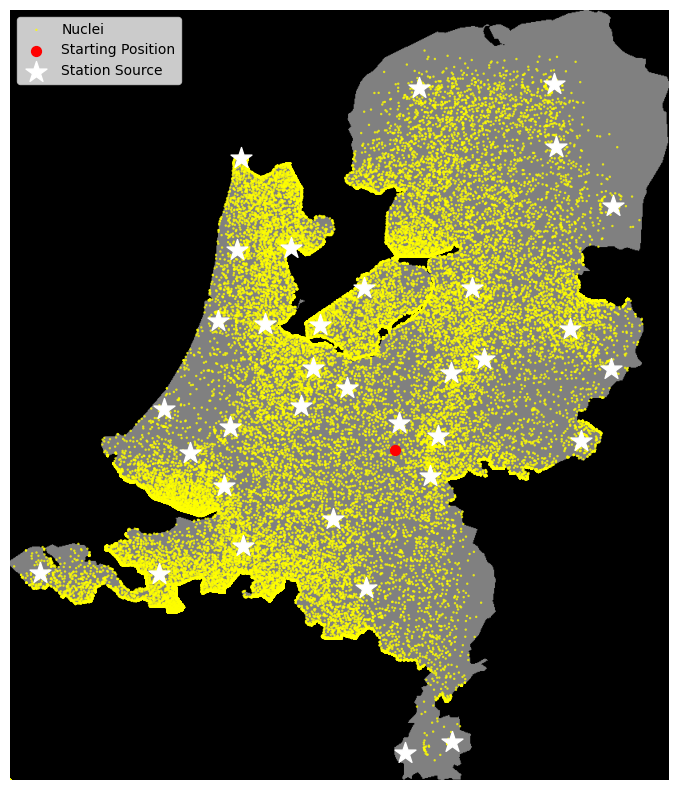

In [9]:
# visualize the map with stations
def visualize_map_with_stations(map_with_stations, stations, nuclei = None, starting_positions = None, save_path=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(map_with_stations.T, cmap='gray')
    if nuclei is not None:
        plt.scatter(nuclei[:,:,0].flatten(), nuclei[:,:,1].flatten(), c='yellow', alpha=0.8, s=3, edgecolors='none', label='Nuclei')
    if starting_positions is not None:
        plt.scatter(starting_positions[0], starting_positions[1], c='red', marker='o', s=50, label='Starting Position')
    plt.scatter(stations[:, 0], stations[:, 1], c='white', marker='*', s=250, label='Station Source')
    # plt.title('Map with Stations')
    # plt.xlabel('X Coordinate')
    # plt.ylabel('Y Coordinate')
    plt.xlim(0, map_with_stations.shape[0])
    plt.ylim(0, map_with_stations.shape[1])  # Invert y-axis to match image coordinates
    # turn the axes off
    plt.gca().set_axis_off()
    plt.legend()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    
# For the first file, visualize the nuclei
visualize_map_with_stations(map_with_stations, stations, all_trails[0][::20], starting_positions[0], save_path='nuclei_distribution.png')

In [10]:
# Create a mesh graph from the nuclei data
results = ResultSet(
    path=folder,
    all_trails=np.array(all_trails[0]),
    seed=np.array([np.random.randint(0, 10000) for _ in range(len(filenames))]),
    nuclei=np.array(nuclei_data[0]),
    stations=np.array(stations),
    map_with_stations=np.array(map_with_stations),
    start_pos=np.array(starting_positions[0])
)
# Create the nuclei graph
G = create_nuclei_graph(results)
# Prune the edges by the map
pruned_G = prune_edges_by_map(G, results, max_water_crossings=2)

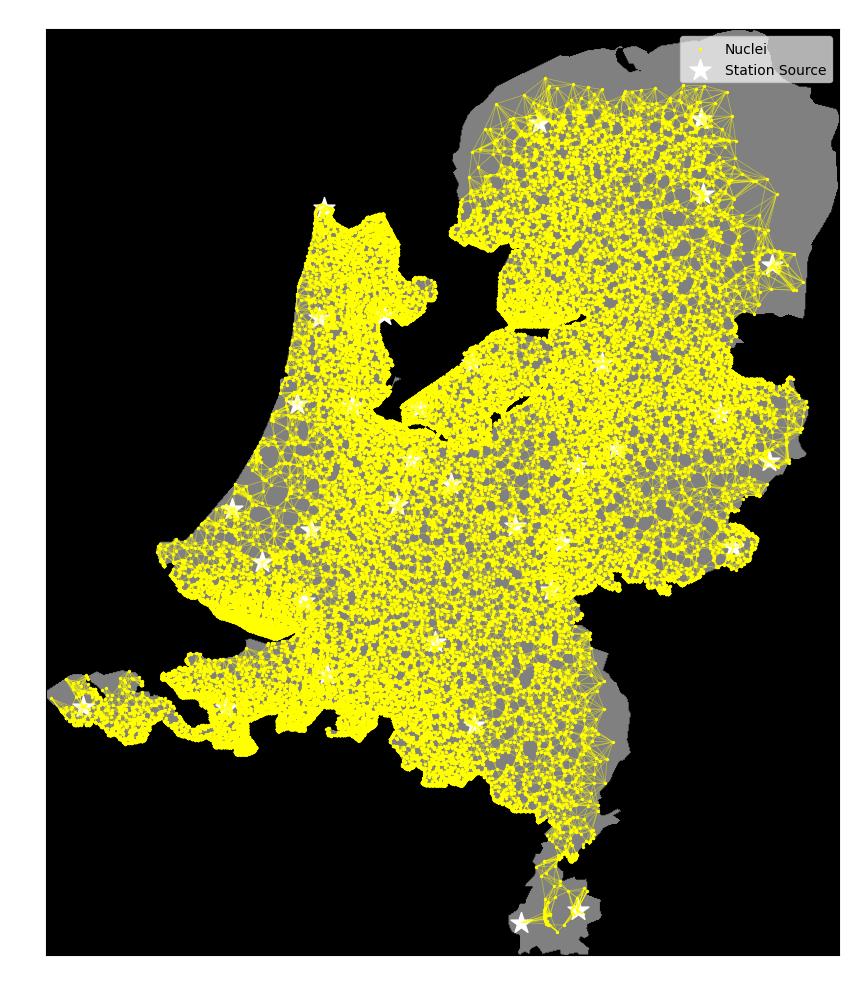

In [86]:
from matplotlib.collections import LineCollection

def visualize_mesh_with_background(points, edges, station_points, map_with_stations, 
                                  title='10-Nearest Neighbor Proximity Mesh', 
                                  save_path=None):
    """
    Visualize a mesh network on top of a map using LineCollection for edges.
    
    Args:
        points: (N, 2) array of all node coordinates (x, y).
        edges: (M, 2) array of edge indices (into points).
        station_points: (K, 2) array of station coordinates (x, y).
        map_with_stations: 2D array for the background map.
        title: Title for the plot.
        save_path: If given, save the figure to this path.
    """
    # Prepare edge segments for LineCollection
    edge_segments = np.stack([
        np.stack([points[edges[:, 0]], points[edges[:, 1]]], axis=1)
    ], axis=0).reshape(-1, 2, 2)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('black')
    ax.imshow(map_with_stations.T, cmap='gray', origin='lower')

    # Draw all edges at once
    lc = LineCollection(edge_segments, colors='yellow', linewidths=0.5, alpha=0.5)
    ax.add_collection(lc)

    # Draw points
    ax.scatter(points[:, 0], points[:, 1], c='yellow', s=2, label='Nuclei')
    ax.scatter(station_points[:, 0], station_points[:, 1], c='white', marker='*', s=250, label='Station Source')

    ax.set_xlim(0, map_with_stations.shape[0])
    ax.set_ylim(0, map_with_stations.shape[1])
    ax.set_title(title, color='white')
    ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
    ax.tick_params(colors='white')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Visualize the pruned graph with the map
visualize_mesh_with_background(
    results.all_points, 
    np.array(pruned_G.edges), 
    results.stations, 
    results.map_with_stations, 
    title='Pruned Proximity Mesh',
    save_path=f'pruned_mesh.png'
)

In [11]:
# Create the refined station network
proximities = [1,2,3,4,5]
refined_graphs, distances = build_refined_station_network(pruned_G, results, proximities)

  0%|          | 0/34 [00:00<?, ?it/s]

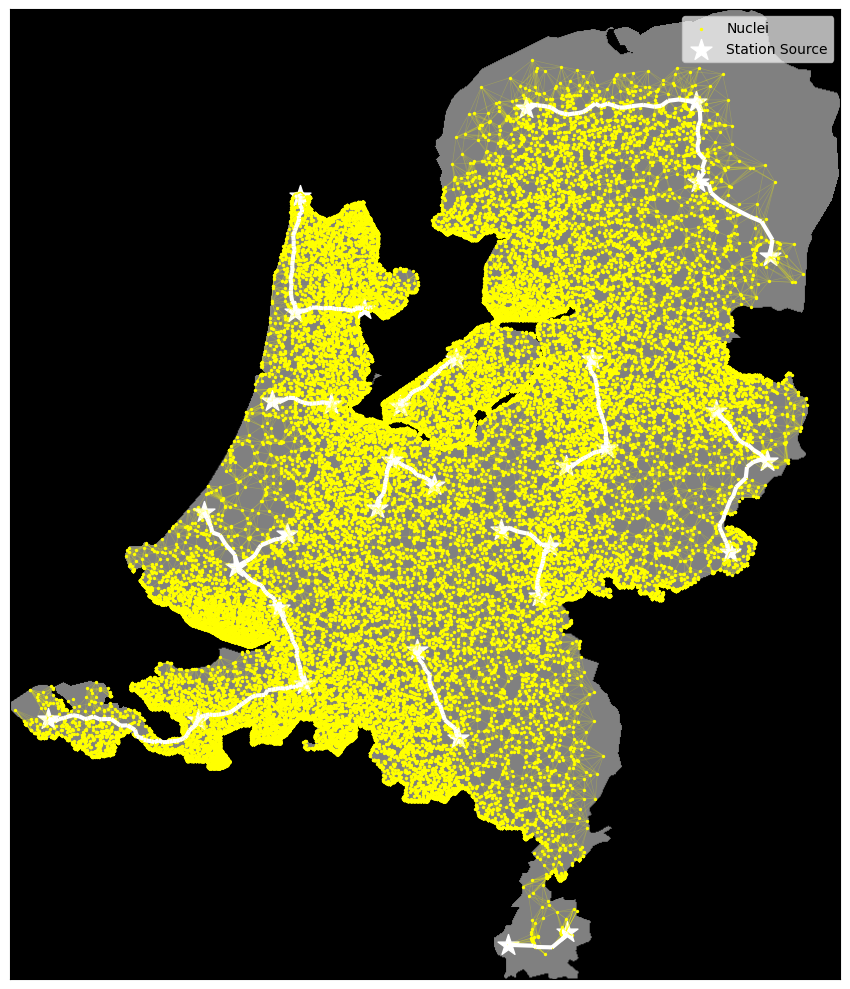

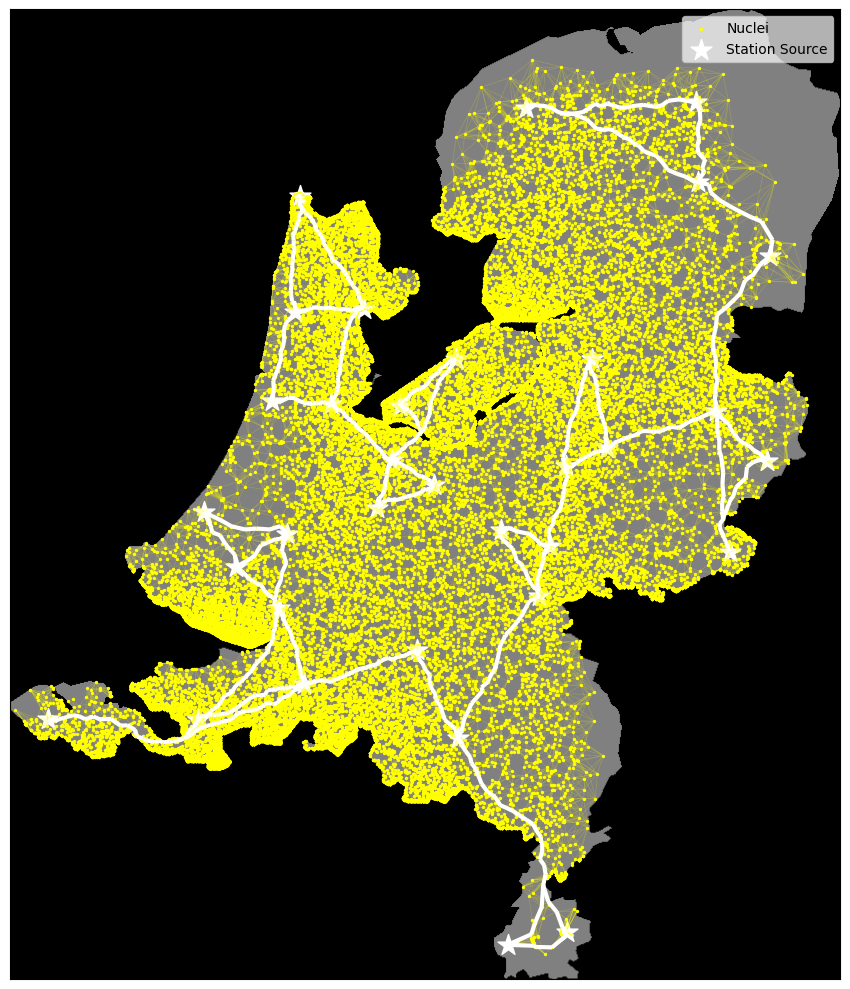

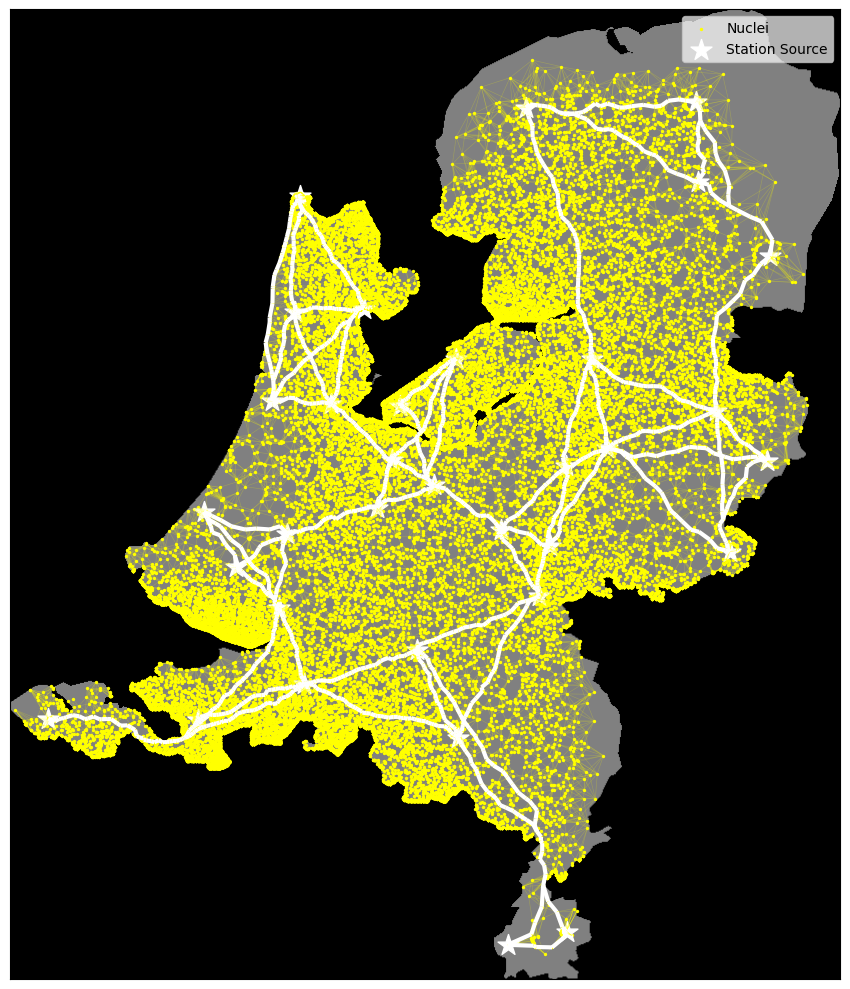

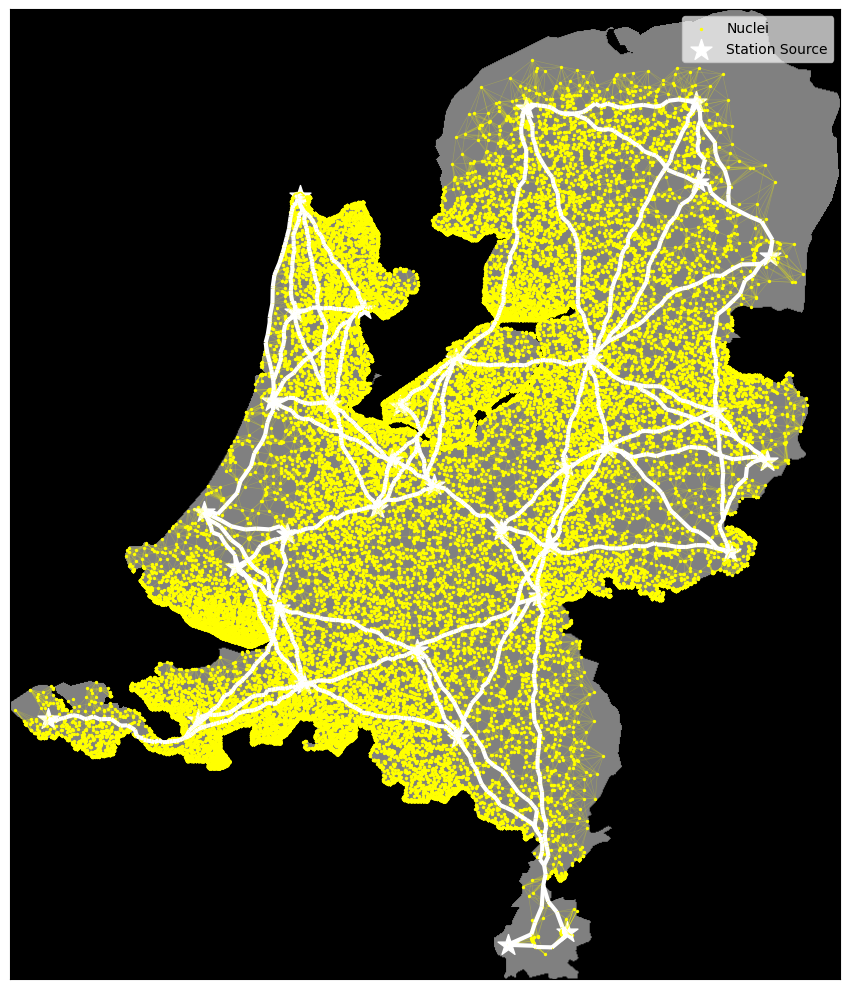

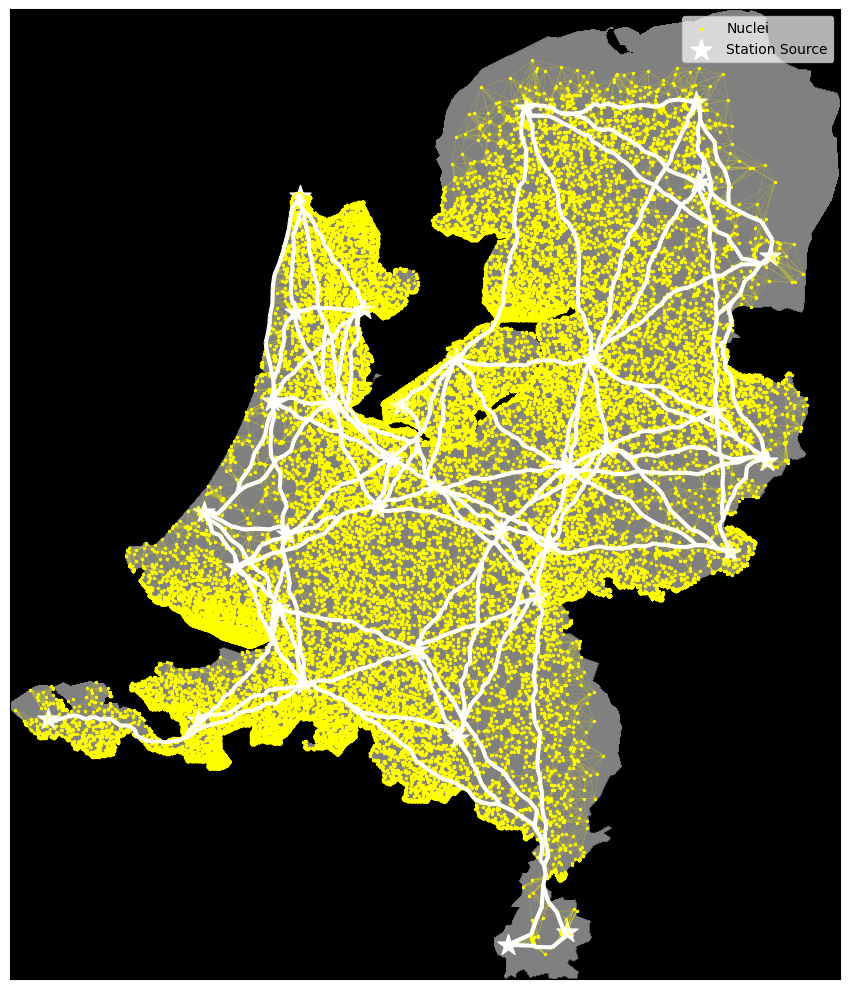

In [95]:
from matplotlib.collections import LineCollection

def visualize_refined_network_with_background(
    all_points, pruned_edges, refined_segments, stations, map_with_stations,
    title='Refined Shortest-Walk Network (Stage 2)', save_path=None
):
    """
    Visualize the refined network on top of the map, with the pruned mesh faintly in the background.

    Args:
        all_points: (N, 2) array of all node coordinates (x, y).
        pruned_edges: (M, 2) array of edge indices for the pruned mesh.
        refined_segments: (K, 2, 2) array of line segments for the refined network.
        stations: (S, 2) array of station coordinates (x, y).
        map_with_stations: 2D array for the background map.
        title: Title for the plot.
        save_path: If given, save the figure to this path.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('black')

    # Prepare pruned mesh edge segments
    pruned_edge_segments = np.stack([
        np.stack([all_points[pruned_edges[:, 0]], all_points[pruned_edges[:, 1]]], axis=1)
    ], axis=0).reshape(-1, 2, 2)

    # Draw pruned edges faintly
    lc_pruned = LineCollection(pruned_edge_segments, colors='yellow', linewidths=0.5, alpha=0.2)
    ax.add_collection(lc_pruned)

    # Draw the map with stations
    ax.imshow(map_with_stations.T, cmap='gray', origin='lower')

    # Draw refined network edges
    lc = LineCollection(refined_segments, colors='white', linewidths=3)
    ax.add_collection(lc)

    # Draw points
    ax.scatter(all_points[:, 0], all_points[:, 1], c='yellow', s=2, label='Nuclei')
    ax.scatter(stations[:, 0], stations[:, 1], c='white', marker='*', s=250, label='Station Source')

    ax.set_xlim(0, map_with_stations.shape[0])
    ax.set_ylim(0, map_with_stations.shape[1])
    ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
    # set the axes to off
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    # plt.title(title, color='white')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# Visualize the refined network with the map
for p, graph in enumerate(refined_graphs):
    # Extract segments for visualization
    segments = np.array([np.stack([results.all_points[int(i)], results.all_points[int(j)]]) for i, j in graph.edges])
    
    visualize_refined_network_with_background(
        results.all_points, 
        np.array(pruned_G.edges), 
        segments, 
        results.stations, 
        results.map_with_stations, 
        title=f'Refined Shortest-Walk Network (p={proximities[p]})',
        save_path=f'p{proximities[p]}_refined_network.png'
    )